In [12]:
import numpy as np
import pickle 
import os 
import matplotlib.pyplot as plt 
from typing import List, Tuple, Dict, Any, Optional 
from matplotlib import colormaps  
import networkx  
from scipy.spatial import distance 
from sklearn.preprocessing import StandardScaler 
from scipy.stats import entropy 
import warnings 
from skimage import measure 
from networkx.drawing.nx_agraph import graphviz_layout 
from tqdm.auto import tqdm 
from stedfm.loaders import get_dataset 

DEEP_TREE_PATH = "./recursive-clustering-experiment/MAE_SMALL_STED_neural-activity-states_recursive_clusters_tree.pkl"
MANUAL_TREE_PATH = "./recursive-clustering-experiment/manual/MAE_SMALL_STED_neural-activity-states_recursive_clusters_tree.pkl"



##### Helper functions

In [13]:
class Node:
    def __init__(self, cluster_id, depth, data=None):
        self.cluster_id = cluster_id
        self.depth = depth
        self.data = data
        self.parent = None
        self.children = []
    
    def add_child(self, child_node):
        child_node.parent = self
        self.children.append(child_node)
    
    def __str__(self):
        return f"Node(cluster_id={self.cluster_id}, depth={self.depth}, children={len(self.children)})"
    
    def __repr__(self):
        return self.__str__()

def print_tree(node, indent=0):
    """Helper function to visualize the tree structure"""
    print("  " * indent + str(node))
    if node.data is not None:
        print("  " * (indent + 1) + f"Data: {node.data}")
    for child in node.children:
        print_tree(child, indent + 1)

def build_tree_from_nested_lists(nested_lists, depth=0, parent_id=0):
    """
    Recursively builds a tree from nested lists.
    
    Args:
        nested_lists: A list that may contain nested lists or data elements
        depth: Current depth in the tree
        parent_id: Cluster ID of the parent node
    
    Returns:
        The root node of the tree
    """
    # Create a root node for the current level
    current_id = parent_id
    root = Node(cluster_id=current_id, depth=depth)
    
    # Process each item in the nested list
    for i, item in enumerate(nested_lists):
        # Assign a unique cluster ID for the current node
        current_id = parent_id * 100 + i + 1
        
        if isinstance(item, list):
            # Recursive case: item is a nested list (cluster)
            child_node = build_tree_from_nested_lists(item, depth + 1, current_id)
            root.add_child(child_node)
            # print(f"child_node: {child_node.parent}")
        else:
            # Base case: item is data
            leaf_node = Node(cluster_id=current_id, depth=depth + 1, data=item)
            root.add_child(leaf_node)
            # print(f"leaf_node: {leaf_node.parent}")
    
    return root

def load_data(data_path: str):
    with open(data_path, "rb") as f:
        data = pickle.load(f)
    return data

def find_leaf_nodes(node, leaves=None):
    if leaves is None:
        leaves = []
    
    if not node.children:  # This is a leaf node
        leaves.append(node)
    else:
        for child in node.children:
            find_leaf_nodes(child, leaves)
            
    return leaves

def get_depth_nodes(root, depth):
    for child in root.children:
        if child.depth == depth:
            yield child
        else:
            yield from get_depth_nodes(child, depth)

def compute_similarity(vector1, vector2):
    similarity = 1 - distance.cosine(vector1, vector2)  
    return similarity

def extract_mean_feature_vector(node):
    leaf_nodes = find_leaf_nodes(node)
    all_data = np.concatenate([leaf.data["data"] for leaf in leaf_nodes])
    return np.mean(all_data, axis=0)

def get_average_features(node, dataset):
    leaf_nodes = find_leaf_nodes(node)
    total = 0
    area, intensity, eccentricity, nn, num_proteins, density, blur_effect, shannon_entropy, signal_to_noise = [], [], [], [], [], [], [], [], []
    for leaf in leaf_nodes:
        total += leaf.data["data"].shape[0]
        try:
            data_idx = [item["dataset-idx"].item() for item in leaf.data["metadata"]]
        except:
            data_idx = [item["dataset-idx"] for item in leaf.data["metadata"]]
        imgs = [dataset[idx][0].squeeze().numpy() for idx in data_idx]
        masks = [dataset[idx][1]["mask"] for idx in data_idx]
        for img, mask in zip(imgs, masks):
            label_image, nprots = measure.label(mask, return_num=True)
            # Image-level features
            num_proteins.append(nprots)
            br = measure.blur_effect(img)
            blur_effect.append(br)
            shannon_entropy.append(measure.shannon_entropy(img))
            foreground_intensity = np.mean(img[mask])
            inverted_mask = np.logical_not(mask)
            background_intensity = np.mean(img[inverted_mask])
            signal_to_noise.append(foreground_intensity / background_intensity)
            
            rprops = measure.regionprops(label_image, intensity_image=img)
            centroids = [r.weighted_centroid for r in rprops]
            if len(centroids) == 1:
                density.append(1.0)
            else:
                distance_matrix = distance.cdist(centroids, centroids, metric="euclidean")
                distance_matrix = np.sort(distance_matrix, axis=1)
                img_density = []
                for d in range(distance_matrix.shape[0]):
                    num_neighbors = np.sum(distance_matrix[d] < 50)
                    img_density.append(num_neighbors)
                density.append(np.mean(img_density))
                
            img_area, img_intensity, img_eccentricity, img_nn = [], [], [], []
            for rprop in rprops:
                distances = distance.cdist(centroids, [rprop.weighted_centroid], metric="euclidean")
                distances = distances[1:]
                if distances.shape[0] > 0:
                    img_nn.append(np.min(distances))
                else:
                    img_nn.append(224.0)

                img_area.append(rprop.area)
                img_intensity.append(rprop.mean_intensity)
                img_eccentricity.append(rprop.eccentricity)
            area.append(np.mean(img_area))
            intensity.append(np.mean(img_intensity))
            eccentricity.append(np.mean(img_eccentricity))
            nn.append(np.mean(img_nn))


    nn = [value for value in nn if not np.isnan(value)]
    area = np.mean(area)
    intensity = np.mean(intensity)
    eccentricity = np.mean(eccentricity)
    nn = np.mean(nn)
    num_proteins = np.mean(num_proteins)
    density = np.mean(density)
    blur_effect = np.mean(blur_effect)
    shannon_entropy = np.mean(shannon_entropy)
    signal_to_noise = np.mean(signal_to_noise)
    average_features = np.array([area, intensity, eccentricity, nn, num_proteins, density, blur_effect, shannon_entropy, signal_to_noise])
    
    return average_features, total

##### Dataset

In [14]:
_, _, test_loader = get_dataset(
    name="neural-activity-states",
    transform=None,
    training=True,
    patch=None,
    batch_size=64,
    n_channels=1,
    balance=False,
)

dataset = test_loader.dataset

Processing dataset..: 100%|██████████| 1510/1510 [00:01<00:00, 1260.74it/s]


=== NAS dataset ===
(array([0, 1, 2, 3]), array([1545, 1423,  512, 2541]))
(array([0, 1, 2, 3]), array([230, 420, 113, 413]))
(array([0, 1, 2, 3]), array([492, 299, 200, 519]))
Training size: 6021
Validation size: 1176
Test size: 1510




In [15]:
def build_graph(data):
    tree = build_tree_from_nested_lists(data)
    all_nodes = find_leaf_nodes(tree)
    print(f"=== Graph has {len(all_nodes)} leaf nodes ===")
    max_depth = max([node.depth for node in all_nodes])
    graph = networkx.DiGraph() 
    root_features, root_count = get_average_features(tree, dataset)
    graph.add_node(
        tree.cluster_id, 
        area=root_features[0], 
        intensity=root_features[1], 
        eccentricity=root_features[2], 
        nn=root_features[3], 
        num_proteins=root_features[4],
        density=root_features[5],
        blur_effect=root_features[6],
        shannon_entropy=root_features[7],
        signal_to_noise=root_features[8],
        count=root_count
    )
    for d in range(1, max_depth + 1):
        depth_nodes = list(get_depth_nodes(tree, d))
        print(f"Depth {d} has {len(depth_nodes)} nodes")
        total_proteins = 0
        for node in tqdm(depth_nodes, desc=f"Depth {d}"):
            node_features, node_count = get_average_features(node, dataset)
            total_proteins += node_count
            node_vector = extract_mean_feature_vector(node)
            parent_vector = extract_mean_feature_vector(node.parent)
            similarity = compute_similarity(node_vector, parent_vector)
            graph.add_node(
                node.cluster_id,
                area=node_features[0],
                intensity=node_features[1],
                eccentricity=node_features[2],
                nn=node_features[3],
                num_proteins=node_features[4],
                density=node_features[5],
                blur_effect=node_features[6],
                shannon_entropy=node_features[7],
                signal_to_noise=node_features[8],
                count=node_count
            )
            graph.add_edge(
                node.parent.cluster_id,
                node.cluster_id,
                weight=similarity
            )
        print(f"Total proteins: {total_proteins}")
    
    return graph 

deep_data = load_data(DEEP_TREE_PATH)
manual_data = load_data(MANUAL_TREE_PATH)

print(f"[---] Deep graph [---]")
deep_graph = build_graph(deep_data)
print(f"[---] Manual graph [---]")
manual_graph = build_graph(manual_data)


[---] Deep graph [---]
=== Graph has 68 leaf nodes ===


/opt/anaconda3/envs/phd-env/lib/python3.8/site-packages/skimage/measure/_regionprops.py:647: RuntimeWarning: invalid value encountered in scalar divide
  tuple(M[_get_element(axis)] / M0 for axis in range(self._ndim)))


Depth 1 has 2 nodes


Depth 1: 100%|██████████| 2/2 [00:19<00:00,  9.78s/it]


Total proteins: 1510
Depth 2 has 4 nodes


Depth 2: 100%|██████████| 4/4 [00:19<00:00,  4.89s/it]


Total proteins: 1510
Depth 3 has 8 nodes


Depth 3: 100%|██████████| 8/8 [00:19<00:00,  2.42s/it]


Total proteins: 1510
Depth 4 has 14 nodes


Depth 4: 100%|██████████| 14/14 [00:14<00:00,  1.06s/it]


Total proteins: 1136
Depth 5 has 20 nodes


Depth 5: 100%|██████████| 20/20 [00:10<00:00,  1.82it/s]


Total proteins: 884
Depth 6 has 28 nodes


Depth 6: 100%|██████████| 28/28 [00:08<00:00,  3.37it/s]


Total proteins: 655
Depth 7 has 36 nodes


Depth 7: 100%|██████████| 36/36 [00:06<00:00,  5.76it/s]


Total proteins: 484
Depth 8 has 16 nodes


Depth 8: 100%|██████████| 16/16 [00:02<00:00,  7.53it/s]


Total proteins: 164
Depth 9 has 6 nodes


Depth 9: 100%|██████████| 6/6 [00:00<00:00,  7.46it/s]


Total proteins: 53
[---] Manual graph [---]
=== Graph has 45 leaf nodes ===
Depth 1 has 2 nodes


Depth 1: 100%|██████████| 2/2 [00:19<00:00,  9.56s/it]


Total proteins: 1508
Depth 2 has 4 nodes


Depth 2: 100%|██████████| 4/4 [00:19<00:00,  4.79s/it]


Total proteins: 1508
Depth 3 has 4 nodes


Depth 3: 100%|██████████| 4/4 [00:14<00:00,  3.56s/it]


Total proteins: 1131
Depth 4 has 8 nodes


Depth 4: 100%|██████████| 8/8 [00:14<00:00,  1.79s/it]


Total proteins: 1131
Depth 5 has 14 nodes


Depth 5: 100%|██████████| 14/14 [00:10<00:00,  1.29it/s]


Total proteins: 830
Depth 6 has 18 nodes


Depth 6: 100%|██████████| 18/18 [00:08<00:00,  2.16it/s]


Total proteins: 667
Depth 7 has 16 nodes


Depth 7: 100%|██████████| 16/16 [00:04<00:00,  3.68it/s]


Total proteins: 369
Depth 8 has 12 nodes


Depth 8: 100%|██████████| 12/12 [00:01<00:00,  7.74it/s]


Total proteins: 129
Depth 9 has 6 nodes


Depth 9: 100%|██████████| 6/6 [00:00<00:00, 10.39it/s]


Total proteins: 50
Depth 10 has 4 nodes


Depth 10: 100%|██████████| 4/4 [00:00<00:00, 10.84it/s]

Total proteins: 32


In [17]:
paths, cost = networkx.optimal_edit_paths(deep_graph, manual_graph)
print(len(paths))
print(cost)

KeyboardInterrupt: 

In [5]:
deep_degrees = [val for (node, val) in deep_graph.degree()]
manual_degrees = [val for (node, val) in manual_graph.degree()]

print(f"Deep graph: {np.mean(deep_degrees)}")
print(f"Manual graph: {np.mean(manual_degrees)}")



Deep graph: 1.9851851851851852
Manual graph: 1.9775280898876404


In [6]:
def extract_node_features(
        graph,
        feature_keys=["area", "intensity", "eccentricity", "nn", "num_proteins", "density", "blur_effect", "shannon_entropy", "signal_to_noise"]
):
    features = [] 
    for node in graph.nodes():
        node_features = [] 
        for key in feature_keys:
            value = graph.nodes[node][key]
            node_features.append(value)
        features.append(node_features)
    return np.array(features)
        

Manual stats: 1.5568880820326925e-05, 0.07437378205566547, 0.09942967517930885, 0.3924220659997971
Deep stats: 1.5568880820326925e-05, 0.08424623980470936, 0.12475298199029072, 0.6780678959365216


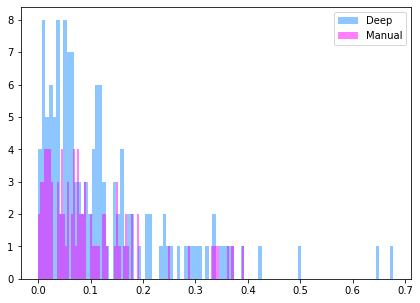

In [7]:
from scipy.stats import gaussian_kde
deep_features = extract_node_features(deep_graph)
manual_features = extract_node_features(manual_graph)
combined = np.vstack([deep_features, manual_features])
scaler = StandardScaler()
scaler.fit(combined)
deep_scaled_features = scaler.transform(deep_features)
manual_scaled_features = scaler.transform(manual_features)
similarity_matrix = distance.cdist(deep_scaled_features, manual_scaled_features, metric="cosine")

deep_similarity_min = np.min(similarity_matrix, axis=1)
manual_similarity_min = np.min(similarity_matrix, axis=0)

deep_kernel = gaussian_kde(deep_similarity_min)
manual_kernel = gaussian_kde(manual_similarity_min)
print(f"Manual stats: {np.min(manual_similarity_min)}, {np.median(manual_similarity_min)}, {np.mean(manual_similarity_min)}, {np.max(manual_similarity_min)}")
print(f"Deep stats: {np.min(deep_similarity_min)}, {np.median(deep_similarity_min)}, {np.mean(deep_similarity_min)}, {np.max(deep_similarity_min)}")
x = np.linspace(0, 1, 1000)
deep_pdf = deep_kernel.pdf(x)
manual_pdf = manual_kernel.pdf(x)


fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
ax.hist(deep_similarity_min, bins=100, alpha=0.5, label="Deep", color="dodgerblue")
ax.hist(manual_similarity_min, bins=100, alpha=0.5, label="Manual", color="fuchsia")
ax.legend()
plt.show()



In [8]:
from scipy.optimize import linear_sum_assignment

def compute_mutual_information_assignment(G1, G2, metric='euclidean'):
    """
    Compute mutual information between graphs using 1-to-1 node assignment based on feature similarity.
    
    Args:
        G1, G2: NetworkX graphs with node features
: List of node feature keys to use for comparison
        metric: Distance metric for cost matrix ('euclidean', 'cosine', etc.)
        
    Returns:
        Dictionary with mutual information metrics
    """
    # Extract feature vectors for all nodes in both graphs
    features1 = extract_node_features(G1)
    features2 = extract_node_features(G2)

    scaler = StandardScaler()
    combined = np.vstack([features1, features2])
    scaler.fit(combined)
    features1 = scaler.transform(features1)
    features2 = scaler.transform(features2)
    
    # Get dimensions
    n1 = features1.shape[0]
    n2 = features2.shape[0]
    
    
    # Compute cost matrix (distance between feature vectors)
    M = distance.cdist(features1, features2, metric=metric)
    
    # Normalize cost matrix to have similar scales across different features
    if np.max(M) > 0:
        M = M / np.max(M)
    
    # Make the cost matrix square for the assignment problem
    # If graphs have different numbers of nodes, we need to pad the smaller one
    if n1 > n2:
        # Pad with max cost to ensure these won't be matched unless necessary
        pad_value = np.max(M) + 1.0
        padding = np.ones((n1, n1 - n2)) * pad_value
        M_padded = np.hstack([M, padding])
    elif n2 > n1:
        pad_value = np.max(M) + 1.0
        padding = np.ones((n2 - n1, n2)) * pad_value
        M_padded = np.vstack([M, padding])
    else:
        M_padded = M
    
    # Solve the assignment problem
    row_ind, col_ind = linear_sum_assignment(M_padded)

    threshold = np.where(M_padded > 0.2)

    
    # Calculate the total assignment cost
    assignment_cost = M_padded[row_ind, col_ind].sum()
    
    # Create assignment matrix (1 where nodes are matched, 0 elsewhere)
    assignment_matrix = np.zeros_like(M_padded)
    assignment_matrix[row_ind, col_ind] = 1
    print(f"Before threshold: {np.count_nonzero(assignment_matrix)}")
    assignment_matrix[threshold] = 0
    print(f"After threshold: {np.count_nonzero(assignment_matrix)}")

    
    
    # Trim the matrix back to original size
    if n1 > n2 or n2 > n1:
        assignment_matrix = assignment_matrix[:n1, :n2]

    num_deep_unassigned = 0
    for i in range(assignment_matrix.shape[0]):
        if np.sum(assignment_matrix[i]) == 0:
            num_deep_unassigned += 1
    print(f"Number of deep nodes unassigned: {num_deep_unassigned}")

    num_manual_unassigned = 0
    for i in range(assignment_matrix.shape[1]):
        if np.sum(assignment_matrix[:, i]) == 0:
            num_manual_unassigned += 1
    print(f"Number of manual nodes unassigned: {num_manual_unassigned}")
    
    # Convert to a proper probability distribution
    P_joint = assignment_matrix / assignment_matrix.sum()
    
    # Compute marginal probabilities
    P_G1 = np.sum(P_joint, axis=1)
    P_G2 = np.sum(P_joint, axis=0)
    
    # Replace zero probabilities to avoid log(0)
    P_G1[P_G1 <= 0] = 1e-10
    P_G2[P_G2 <= 0] = 1e-10
    P_joint[P_joint <= 0] = 1e-10
    
    # Normalize to ensure they sum to 1
    P_G1 = P_G1 / P_G1.sum()
    P_G2 = P_G2 / P_G2.sum()
    P_joint = P_joint / P_joint.sum()
    
    # Compute entropies
    H_G1 = entropy(P_G1, base=2)
    H_G2 = entropy(P_G2, base=2)
    
    # Compute joint entropy
    P_joint_flat = P_joint.flatten()
    P_joint_flat = P_joint_flat[P_joint_flat > 0]  # Remove zeros
    H_joint = -np.sum(P_joint_flat * np.log2(P_joint_flat))
    
    # Mutual information = H(X) + H(Y) - H(X,Y)
    mi = H_G1 + H_G2 - H_joint
    
    # Normalized mutual information
    nmi = 2 * mi / (H_G1 + H_G2) if (H_G1 + H_G2) > 0 else 0
    
    # Information unique to each graph
    info_G1_not_G2 = H_G1 - mi
    info_G2_not_G1 = H_G2 - mi
    
    return {
        "assignment_cost": assignment_cost,
        "mutual_information": mi,
        "normalized_mutual_information": nmi,
        "information_in_G1_not_G2": info_G1_not_G2,
        "information_in_G2_not_G1": info_G2_not_G1,
        "assignment_matrix": assignment_matrix[:n1, :n2]  # Return only the valid part
    }



In [9]:
result = compute_mutual_information_assignment(deep_graph, manual_graph)
assignment_matrix = result["assignment_matrix"]

Before threshold: 135
After threshold: 87
Number of deep nodes unassigned: 48
Number of manual nodes unassigned: 2


Original counts - G1: 135, G2: 89
Final graph node count: 224
black 5
4530


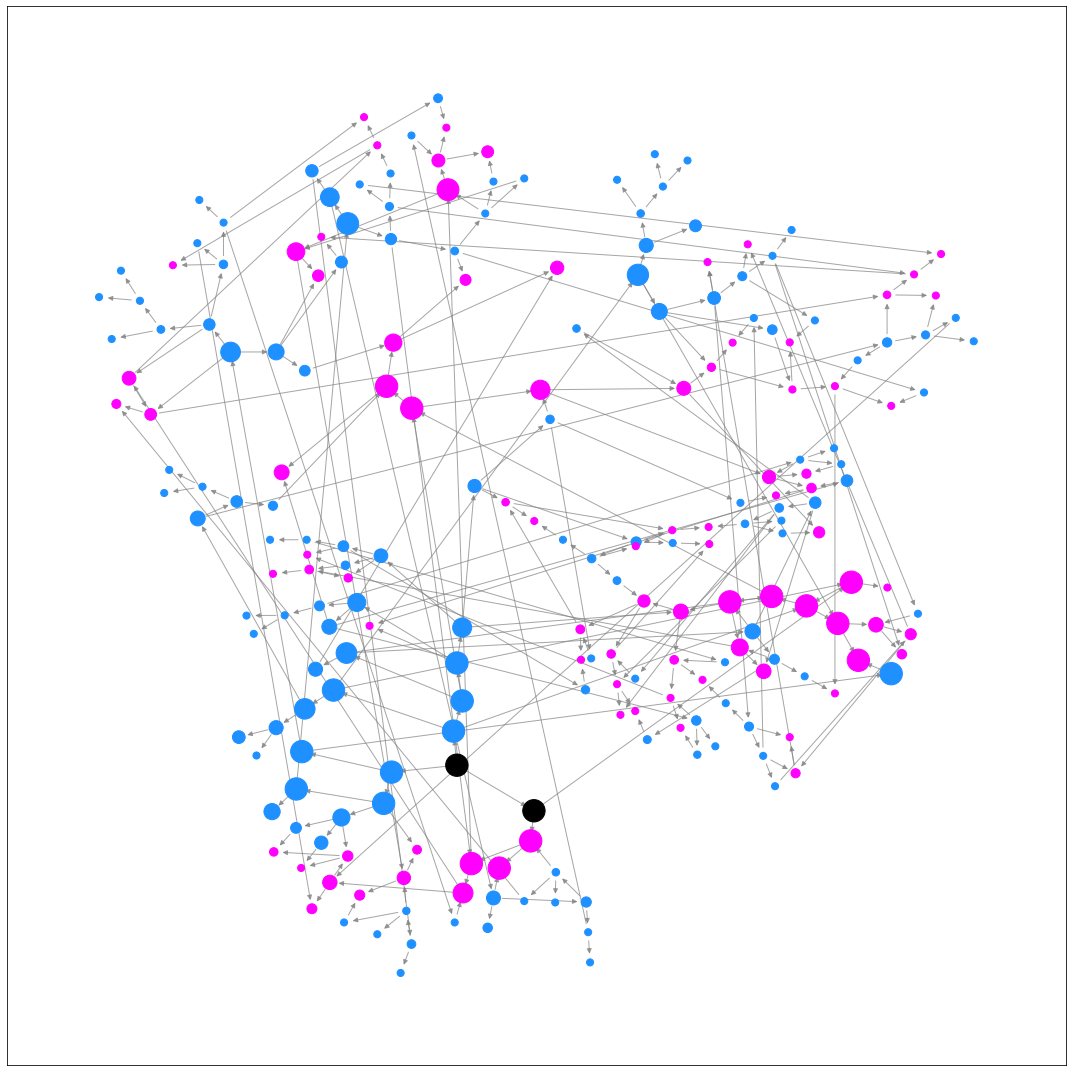

In [10]:
def merge_graphs(g1, g2, assignment_matrix):
    nodes1 = list(g1.nodes())
    nodes2 = list(g2.nodes())
    print(f"Original counts - G1: {len(nodes1)}, G2: {len(nodes2)}")

    # Set colors for nodes
    networkx.set_node_attributes(g1, {node: {"color": "dodgerblue"} for node in nodes1})
    networkx.set_node_attributes(g1, {0: {"color": "black"}})
    networkx.set_node_attributes(g2, {node: {"color": "fuchsia"} for node in nodes2})
    networkx.set_node_attributes(g2, {0: {"color": "black"}})
    # For hierarchical IDs, we'll prefix all nodes in g2 with '9'
    # This ensures they're in a completely different hierarchy
    new_nodes2 = {key: int('9' + str(key)) for key in nodes2}
    g2 = networkx.relabel_nodes(g2, new_nodes2)
    
    # Merge graphs
    graph = networkx.union(g1, g2)
    
    # Add edges from assignment matrix
    nodes1 = list(g1.nodes())
    nodes2 = list(g2.nodes())  # These are the new relabeled nodes
    edges = np.argwhere(assignment_matrix > 0)
    for i, j in edges:
        if i < len(nodes1) and j < len(nodes2):
            graph.add_edge(nodes1[i], nodes2[j])
    
    print(f"Final graph node count: {graph.number_of_nodes()}")
    return graph
    
def display_graph(graph, node_size_scale_factor=3, edge_weight_factor=5.0, min_edge_width=1.0):
    # Get node colors
    nodes = graph.nodes(data=True)
    colors = [node[1]["color"] for node in graph.nodes(data=True)]
    print(colors[0], len(colors[0]))
    
    # edge_weights = np.array([graph[u][v]['weight'] for u, v in graph.edges()])
    # print(edge_weights)
    # edge_weights = (edge_weights - edge_weights.min()) / (edge_weights.max() - edge_weights.min())
    # edge_weights = [item + 1 for item in edge_weights]

    # edge_widths = [min_edge_width + (weight * edge_weight_factor) for weight in edge_weights]
    # edge_widths = [min_edge_width]
    node_sizes = np.array([node[1]["count"] * node_size_scale_factor for node in graph.nodes(data=True)])
    print(np.max(node_sizes))
    node_sizes = np.clip(node_sizes, 50, 500)
    # Create figure
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(111)
    

    # layout = networkx.kamada_kawai_layout(graph)
    layout = graphviz_layout(graph, prog="twopi")
    # layout = networkx.kamada_kawai_layout(graph)
    networkx.draw_networkx_nodes(graph, pos=layout, node_color=colors, node_size=node_sizes)
   #  networkx.draw_networkx_labels(graph, pos=layout)
    networkx.draw_networkx_edges(graph, pos=layout, 
                                alpha=0.7, edge_color='gray')
    

    plt.tight_layout()
    plt.show()


graph = merge_graphs(deep_graph, manual_graph, assignment_matrix)
display_graph(graph)
    

In [11]:
def visualize_node_assignment(G1, G2, assignment_matrix,alpha=0.0):
    """
    Visualize the optimal node assignment between two graphs.
    
    Args:
        G1, G2: NetworkX graphs
        feature_keys: Feature keys to use
        alpha: Weight of structure vs features
    """
    # Compute the assignment
    
    result = compute_mutual_information_assignment(G1, G2)
    
    
    # Create plots
    # fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Plot cost matrix
    features1 = extract_node_features(G1)
    features2 = extract_node_features(G2)
    
    M = distance.cdist(features1, features2, 'euclidean')
    if np.max(M) > 0:
        M = M / np.max(M)
    
    # axes[0].imshow(M, cmap='viridis')
    # axes[0].set_title('Cost Matrix')
    # axes[0].set_xlabel('Graph 2 Nodes')
    # axes[0].set_ylabel('Graph 1 Nodes')
    
    # Plot assignment matrix
    # im = axes[1].imshow(assignment_matrix, cmap='plasma')
    # axes[1].set_title('Node Assignment Matrix (1-to-1)')
    # axes[1].set_xlabel('Graph 2 Nodes')
    # axes[1].set_ylabel('Graph 1 Nodes')
    # plt.colorbar(im, ax=axes[1])
    
    # Draw both graphs with node assignments
    pos1 = graphviz_layout(G1, prog="dot")
    pos2 = graphviz_layout(G2, prog="dot")
    pos2_shifted = {node: (x + 1000, y) for node, (x, y) in pos2.items()}
    
    # Plot assignments between graphs
    assignments = np.argwhere(assignment_matrix > 0)
    
    fig = plt.figure(figsize=(12,7))
    ax = fig.add_subplot(111)
   
    
    # Draw connections between assigned nodes
    node_list1 = list(G1.nodes())
    node_list2 = list(G2.nodes())
    
    counter = 0
    node1_colors= ["gainsboro"]*len(node_list1)
    node2_colors= ["gainsboro"]*len(node_list2)
    for i, j in assignments:
        if i < len(node_list1) and j < len(node_list2):  # Check bounds
            # fig = plt.figure(figsize=(12,7))
            # ax = fig.add_subplot(111)
            node1 = node_list1[i]
            node2 = node_list2[j]
            node1_colors[i] = "dodgerblue"
            node2_colors[j] = "fuchsia"

            x1, y1 = pos1[node1]
            x2, y2 = pos2_shifted[node2]
            ax.plot([x1, x2], [y1, y2], 'r--', linewidth=0.5, alpha=0.3)
            #plt.tight_layout()
            #fig.savefig(f"./graph-assignment/graph-{counter}.pdf", dpi=1200, bbox_inches="tight")
            # plt.show()
            #plt.close(fig)
            #counter += 1

    networkx.draw_networkx(G1, pos=pos1, ax=ax, node_color=node1_colors, 
                node_size=50, with_labels=False)
    
    networkx.draw_networkx(G2, pos=pos2_shifted, ax=ax, node_color=node2_colors, 
                    node_size=50, with_labels=False)


    plt.tight_layout()
    plt.show()
    plt.close(fig)
    # fig.savefig("./graph-assignment/graph-all-unassigned.pdf", dpi=1200, bbox_inches="tight")
    # plt.close(fig)
    
    # Add text labels for information measures
    # info_text = (
    #     f"Assignment Cost: {result['assignment_cost']:.4f}\n"
    #     f"Mutual Information: {result['mutual_information']:.4f}\n"
    #     f"Normalized MI: {result['normalized_mutual_information']:.4f}\n"
    #     f"Info in G1 not in G2: {result['information_in_G1_not_G2']:.4f}\n"
    #     f"Info in G2 not in G1: {result['information_in_G2_not_G1']:.4f}"
    # )
    # ax.text(0.5, -0.1, info_text, transform=ax.transAxes, 
    #             ha='center', bbox=dict(facecolor='white', alpha=0.8))
    
    # ax.set_title('Graph Connections via 1-to-1 Assignment')
    # ax.axis('off')
    
    
    return result

Before threshold: 135
After threshold: 87
Number of deep nodes unassigned: 48
Number of manual nodes unassigned: 2


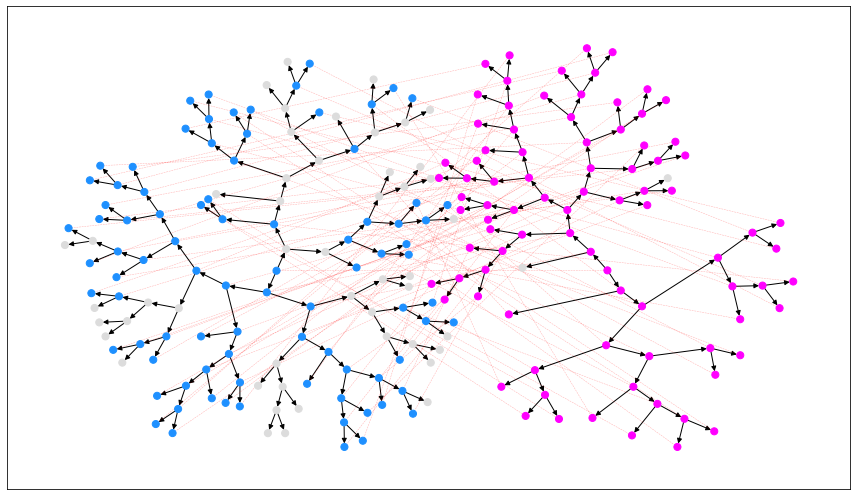

{'assignment_cost': 100.93094785973602,
 'mutual_information': 6.442909977321057,
 'normalized_mutual_information': 0.9999947866879622,
 'information_in_G1_not_G2': 3.3653979028436254e-05,
 'information_in_G2_not_G1': 3.352417147794995e-05,
 'assignment_matrix': array([[1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])}

In [12]:
visualize_node_assignment(deep_graph, manual_graph, assignment_matrix)

In [13]:
unique_deep = np.load("./unique_deep.npz")
unique_manual = np.load("./unique_manual.npz")

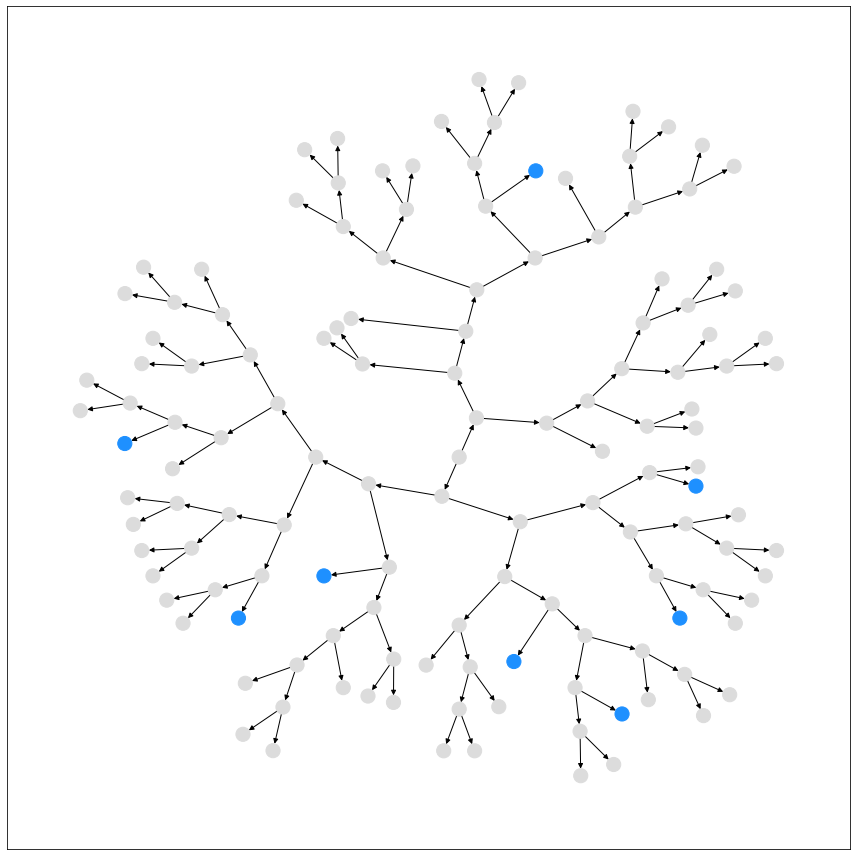

(8,)


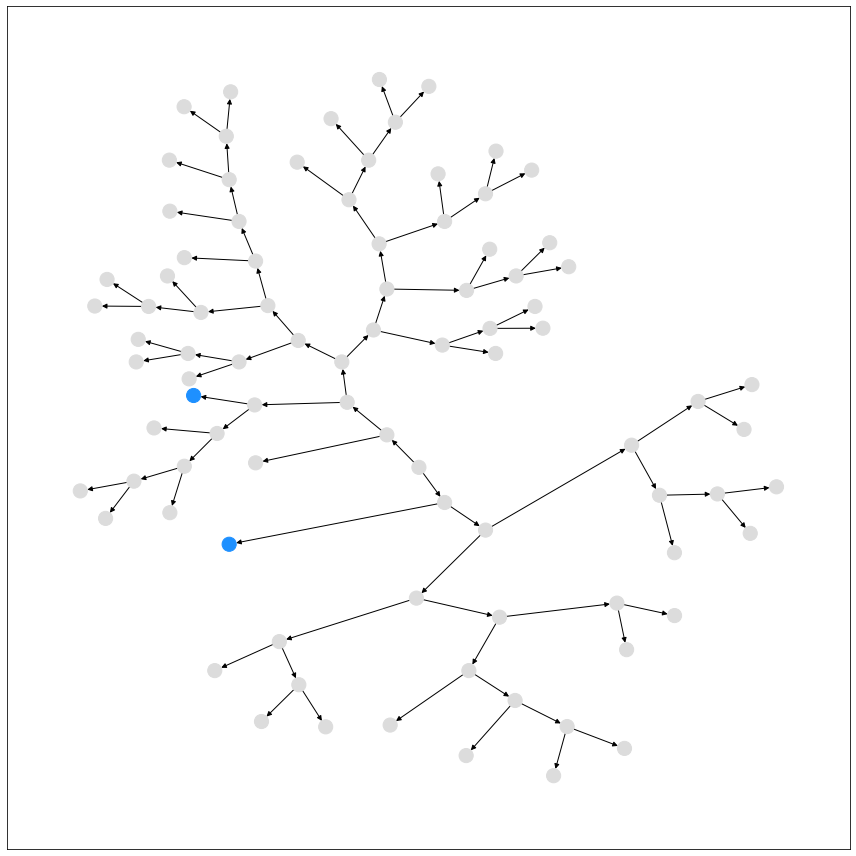

(2,)


In [14]:
def visualize_unique_nodes(G1, node_ids, alpha=0.0):
    for node in G1.nodes():
        print(node)

def visualize_unique_nodes(G, node_ids,alpha=0.0):

    pos1 = graphviz_layout(G, prog="twopi")

    
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111)
   
    
    # Draw connections between assigned nodes
    node_list1 = list(G.nodes())
    node_colors = []
    for node in node_list1:
        if node in node_ids:
            node_colors.append("dodgerblue")
        else:
            node_colors.append("gainsboro")
    # networkx.set_node_attributes(G, {node: {"color": "black"} for node in node_list1})
    # networkx.set_node_attributes(G, {node: {"color": "gainsboro"} for node in node_ids})

    networkx.draw_networkx(G, pos=pos1, ax=ax, node_color=node_colors, 
                node_size=200, with_labels=False)



    plt.tight_layout()
    plt.show()
    plt.close(fig)

    
    

visualize_unique_nodes(deep_graph, unique_deep["unique"])
print(unique_deep["unique"].shape)
visualize_unique_nodes(manual_graph, unique_manual["unique"])
print(unique_manual["unique"].shape)